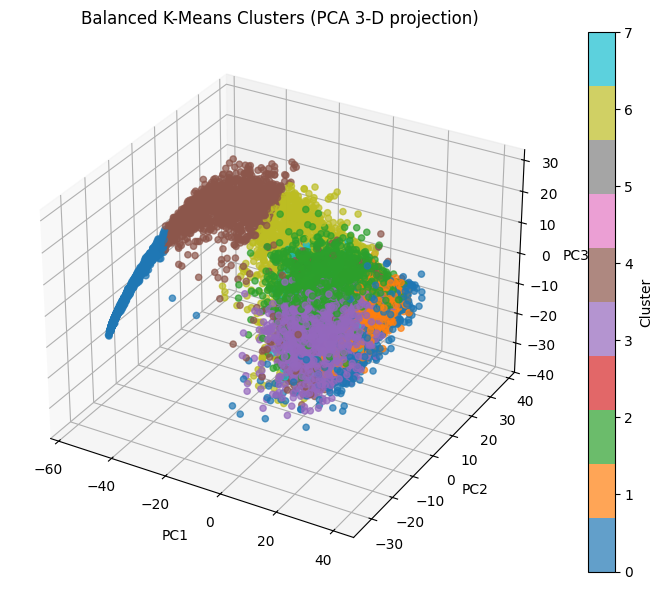

In [ ]:

import os
import numpy as np
import torch
from torch.utils.data import DataLoader
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D   # needed for 3D projection

from helper import SingleNpyDataset

def balanced_kmeans(X: np.ndarray, n_clusters: int, random_state=42) -> np.ndarray:
    N, D = X.shape
    km = KMeans(n_clusters=n_clusters, random_state=random_state).fit(X)
    centers = km.cluster_centers_
    dists = np.linalg.norm(X[:, None, :] - centers[None, :, :], axis=2)

    base = N // n_clusters
    rem  = N % n_clusters
    desired = np.array([base+1]*rem + [base]*(n_clusters - rem))

    labels = -1 * np.ones(N, dtype=int)
    counts = np.zeros(n_clusters, dtype=int)

    flat = [(dists[i, j], i, j)
            for i in range(N) for j in range(n_clusters)]
    flat.sort(key=lambda x: x[0])

    for dist, i, j in flat:
        if labels[i] != -1:
            continue
        if counts[j] < desired[j]:
            labels[i] = j
            counts[j] += 1
        if np.all(counts == desired):
            break

    return labels

# ── LOAD and FLATTEN ─────────────────────────────────────────────
npy_path   = '../ResData/wavefake128_2048split/train/real.npy'
n_clusters = 8

ds = SingleNpyDataset(npy_file=npy_path, label=None)
loader = DataLoader(ds, batch_size=len(ds), shuffle=False)
X_tensor = next(iter(loader))

if X_tensor.ndim > 2:
    X_flat = X_tensor.view(X_tensor.size(0), -1).numpy()
else:
    X_flat = X_tensor.numpy()

# ── CLUSTER ──────────────────────────────────────────────────────
labels = balanced_kmeans(X_flat, n_clusters)

# ── PCA to 3 dimensions ──────────────────────────────────────────
pca = PCA(n_components=3, svd_solver='randomized')
X3 = pca.fit_transform(X_flat)

# ── INTERACTIVE 3D SCATTER PLOT ──────────────────────────────────
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    X3[:, 0], X3[:, 1], X3[:, 2],
    c=labels, cmap='tab10',
    s=20, alpha=0.7
)
cbar = fig.colorbar(scatter, ax=ax, ticks=range(n_clusters))
cbar.set_label('Cluster')
ax.set_title('Balanced K-Means Clusters (PCA 3-D projection)')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.view_init(elev=30, azim=45)

plt.tight_layout()
plt.show()

In [2]:
plt.ion()  # Turn on interactive mode